# Банк - задача классификации

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача**: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### Основные цели:

1. Исследовать данные, не просто вычислять метрики и создавать визуализации.
2. Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка.
3. Проявить фантазию и использовать разные инструменты для повышения качества прогноза.

### План выполнения задачи:

1. Первичная обработка данных

В рамках этой части необходимо обработать пропуски и выбросы в данных. Это необходимо для дальнейшей работы с ними.

2. Разведывательный анализ данных (EDA)

Необходимо исследовать данные, "нащупать" первые закономерности и выдвинуть гипотезы.

3. Отбор и преобразование признаков

Перекодировать и преобразовать данные таким образом, чтобы их можно было использовать при решении задачи классификации. Если на первом этапе мы лишь избавим данные от ненужных артефактов, то на этом шаге совершим действия, более важные для подготовки данных к задаче классификации, уже понимая их структуру.

4. Решение задачи классификации: логистическая регрессия и решающие деревья

Мы построим свою базовую прогностическую модель и оцении ее качество. Подберем оптимальные параметры модели для того, чтобы получить наилучший результат для конкретного алгоритма.

5. Решение задачи классификации: ансамбли моделей и построение прогноза

Здесь стоит доработать свое предсказание с использованием более сложных алгоритмов и оценить, с помощью какой модели возможно сделать более качественные прогнозы.

### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

### Целевая переменная:
* deposit (определяет, согласится ли клиент открыть депозит в банке)

In [1]:
# Импортируем основные библиотеки для работы с данными
import pandas as pd  # Для работы с таблицами данных
import numpy as np   # Для работы с массивами и числовыми вычислениями
import pickle # Для сериализации моделей

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt  # Для базовых графиков
import seaborn as sns           # Для более продвинутой визуализации

# Библиотека Optuna для подбора гиперпараметров
import optuna

# Импортируем модели и инструменты из библиотеки sklearn
from sklearn.ensemble import IsolationForest  # Для обнаружения выбросовp
from sklearn.preprocessing import LabelEncoder  # Для кодирования категориальных переменных
from sklearn.preprocessing import MinMaxScaler # Для маштабирования

# Импортируем модули для работы с моделями
from sklearn import linear_model  # Линейные модели
from sklearn import tree          # Деревья решений
from sklearn import ensemble      # Ансамблевые методы
from sklearn import metrics       # Метрики оценки моделей

# Импортируем инструменты для разделения данных
from sklearn.model_selection import train_test_split, cross_val_score # Для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import GridSearchCV # Для поиска оптимальных гиперпараметров

# Импортируем инструменты для отбора признаков
from sklearn.feature_selection import SelectKBest, f_classif  # Для выбора наиболее значимых признаков

# Отключаем предупреждения, чтобы они не мешали работе
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='pkg_resources')

# 1. Первичная обработка данных

Знакомство с данными, обработка пропусков и выбросов

In [2]:
bank_df = pd.read_csv('Data/bank_fin.csv', sep = ';')

In [3]:
display(bank_df.head(5))
display(bank_df.info())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

In [4]:
# исследуем данные на предмет пропусков
print(f'Пропуски в данных: \n{bank_df.isnull().sum()}')

Пропуски в данных: 
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


# Вывод:

Обнаружилось 25 пропусков в признаке balance, однако стоит дополнительно обратить внимание на данные, возможно они закодированы определенным образом.

In [5]:
# Проверка уникальных значений для каждого категориального признака
categorial_features = bank_df.select_dtypes(include=['object']).columns

unique_values = {}

for feature in categorial_features:
    unique_values[feature] = bank_df[feature].unique()
    
# Вывод результатов
print("Уникальные значения в категориальных данных: \n")
for feature, values in unique_values.items():
    print(f"Признак: {feature}")
    print(f"Уникальные значения: {values}\n")

Уникальные значения в категориальных данных: 

Признак: job
Уникальные значения: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']

Признак: marital
Уникальные значения: ['married' 'single' 'divorced']

Признак: education
Уникальные значения: ['secondary' 'tertiary' 'primary' 'unknown']

Признак: default
Уникальные значения: ['no' 'yes']

Признак: balance
Уникальные значения: [' 2 343,00 $ ' ' 45,00 $ ' ' 1 270,00 $ ' ... ' 1 594,00 $ '
 ' 2 593,00 $ ' '-134,00 $ ']

Признак: housing
Уникальные значения: ['yes' 'no']

Признак: loan
Уникальные значения: ['no' 'yes']

Признак: contact
Уникальные значения: ['unknown' 'cellular' 'telephone']

Признак: month
Уникальные значения: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Признак: poutcome
Уникальные значения: ['unknown' 'other' 'failure' 'success']

Признак: deposit
Уникальные значения: ['yes' 'no']



# Вывод:

В признаке job, contact и education обнаружились закодированные слова unknown. Кроме того в признаке balance присутствует знак доллара и лишняя запятая, что не будет считаться типом float, его нужно будет обработать.

In [6]:
# До преобразования
print(bank_df['balance'].head(10))
print(bank_df['balance'].tail(10))

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
5           0  $ 
6       830,00 $ 
7       545,00 $ 
8         1,00 $ 
9             NaN
Name: balance, dtype: object
11152     390,00 $ 
11153      35,00 $ 
11154     523,00 $ 
11155      80,00 $ 
11156     -72,00 $ 
11157       1,00 $ 
11158     733,00 $ 
11159      29,00 $ 
11160         0  $ 
11161         0  $ 
Name: balance, dtype: object


In [7]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

# Очищаем данные от лишних символов
bank_df['balance'] = bank_df['balance'].str.replace(r'\s+', '', regex=True) # удаляем пробелы
bank_df['balance'] = bank_df['balance'].str.replace('$', '', regex=False) # удаляем символ $
bank_df['balance'] = bank_df['balance'].str.replace(r'[^\d.,-]', '', regex=True)  # оставляем только цифры, точку, запятую и минус

# Заменяем запятую на точку для корректного преобразования
bank_df['balance'] = bank_df['balance'].str.replace(',', '.', regex=False)

# Преобразуем в числовой формат с обработкой ошибок
bank_df['balance'] = pd.to_numeric(bank_df['balance'], errors='coerce')

# Проверяем результат
print(bank_df['balance'].info())

# Проверяем наличие пропущенных значений
print(f"Количество пропущенных значений: {bank_df['balance'].isnull().sum()}")

<class 'pandas.core.series.Series'>
RangeIndex: 11162 entries, 0 to 11161
Series name: balance
Non-Null Count  Dtype  
--------------  -----  
11137 non-null  float64
dtypes: float64(1)
memory usage: 87.3 KB
None
Количество пропущенных значений: 25


In [8]:
# После преобразования
print(bank_df['balance'].head(10))
print(bank_df['balance'].tail(10))

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
5       0.0
6     830.0
7     545.0
8       1.0
9       NaN
Name: balance, dtype: float64
11152    390.0
11153     35.0
11154    523.0
11155     80.0
11156    -72.0
11157      1.0
11158    733.0
11159     29.0
11160      0.0
11161      0.0
Name: balance, dtype: float64


In [9]:
print(f'Среднее значение по преобразованному признаку: {bank_df['balance'].mean():.3f}')

Среднее значение по преобразованному признаку: 1529.129


# Вывод:

Удалось преобразовать данные без потерь (имеется ввиду правильное отображение баланса) до и после.

In [10]:
# обработаем пропуски в признаки balance, заменив их на медианные значения по данному признаку
bank_df['balance'] = bank_df['balance'].fillna(bank_df['balance'].median())
print(f'Среднее значение по преобразованному признаку: {bank_df['balance'].mean():.3f}')

Среднее значение по преобразованному признаку: 1526.936


In [11]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
features_to_fill = ['job', 'education']

for feature_name in features_to_fill:
    bank_df[feature_name] = bank_df[feature_name].apply(
        lambda x: bank_df[feature_name].mode()[0] if x == 'unknown' else x
    )

In [12]:
# Находим самую популярную работу и образование
mask_most_job = bank_df['job'].mode()[0]
mask_most_education = bank_df['education'].mode()[0]

# Фильтруем клиентов с этой работой
filtered_df = bank_df[(bank_df['job'] == mask_most_job) & 
                      (bank_df['education'] == mask_most_education)]

# Рассчитываем средний баланс
average_balance = filtered_df['balance'].mean()
print(f'Средний баланс для клиентов с самой популярной работой и образованием: {average_balance:.3f}')

Средний баланс для клиентов с самой популярной работой и образованием: 1598.883


# Вывод:
На данном этапе удалось справиться с пропусками и заполнить их средним и модальным значением. Теперь стоит обратить внимание на выбросы. Посмотрим на них с помощью метода Тьюки.

Первый квартиль (Q1): 123.0
Третий квартиль (Q3): 1699.0
Межквартильный размах (IQR): 1576.0
Нижняя граница: -2241.0
Верхняя граница: 4063.0
Количество выбросов: 1057


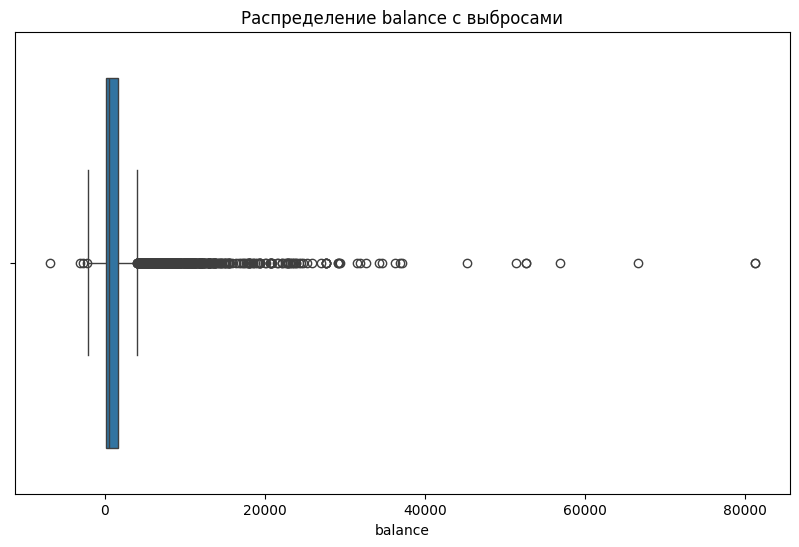

In [13]:
# Определим выбросы по методу Тьюки
# Рассчитаем квартили
Q1 = bank_df['balance'].quantile(0.25)
Q3 = bank_df['balance'].quantile(0.75)

# Определим межквартильный размах
IQR = (Q3 - Q1)

# Определим границы выбросов
lower_bound = (Q1 - 1.5 * IQR)
upper_bound = (Q3 + 1.5 * IQR)

# Выявим выбросы
outliers = bank_df[(bank_df['balance'] < lower_bound) | 
                  (bank_df['balance'] > upper_bound)]

# Выведем результаты
print(f"Первый квартиль (Q1): {Q1}")
print(f"Третий квартиль (Q3): {Q3}")
print(f"Межквартильный размах (IQR): {IQR}")
print(f"Нижняя граница: {round(lower_bound, 4)}")
print(f"Верхняя граница: {round(upper_bound, 4)}")
print(f"Количество выбросов: {len(outliers)}")

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(x=bank_df['balance'])
plt.title('Распределение balance с выбросами')
plt.show()

Количество данных до удаления выбросов: 11162


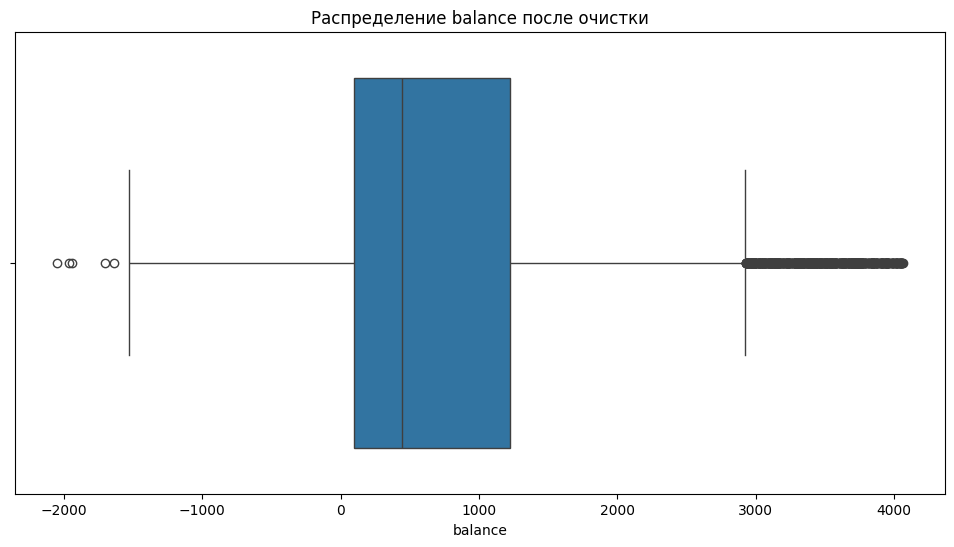

Количество данных после удаления выбросов: 10105


In [14]:
print(f'Количество данных до удаления выбросов: {bank_df['balance'].shape[0]}')

# Создаем маску для не-выбросов
mask = (bank_df['balance'] >= lower_bound) & (bank_df['balance'] <= upper_bound)

# удалим все выбросы для признака balance
bank_df = bank_df[mask]

# Визуальная проверка
plt.figure(figsize=(12, 6))
sns.boxplot(x=bank_df['balance'])
plt.title('Распределение balance после очистки')
plt.show()

print(f'Количество данных после удаления выбросов: {bank_df['balance'].shape[0]}')

# Вывод

При первичной обработки и изучения наших реальных данных удалось:

- Определить и заполнить пропуски
- Преобразовать признак balance в тип float, что критично важно для финансовых данных
- Определить выбросы в данном признаке с помощью простого метода Тьюки
- Убрать выбросы, как нерелевантные для последующей работы с данными

# 2. Разведывательный анализ EDA

### Задание 1

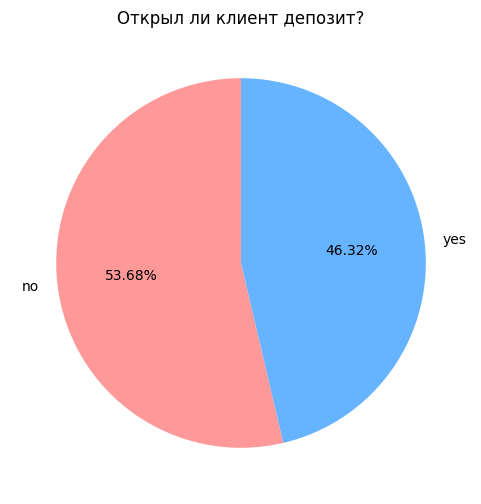

  deposit  count  percentage
0      no   5424   53.676398
1     yes   4681   46.323602

Баланс классов: 86.30%


In [15]:
# изучим соотношение классов в наших данных на предмет несбалансированности, проиллюстрируем результат
# Подсчет частот значений
deposit_counts = bank_df['deposit'].value_counts().reset_index()
deposit_counts.columns = ['deposit', 'count']

# Рассчет процентного соотношения
total = deposit_counts['count'].sum()
deposit_counts['percentage'] = (deposit_counts['count'] / total) * 100

plt.figure(figsize=(6, 6))
plt.pie(
    deposit_counts['count'],
    labels=deposit_counts['deposit'],
    autopct='%1.2f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff']
)

plt.title('Открыл ли клиент депозит?')
plt.show()

print(deposit_counts)

# Проверка баланса классов
class_balance = deposit_counts['count'].min() / deposit_counts['count'].max() * 100
print(f"\nБаланс классов: {class_balance:.2f}%")

# Вывод:

Проанализировав целевую переменную можно сделать выводы, что данные относительно сбалансированы, т.к. процентное соотношение близко к 50 на 50. Баланс классов составляет 86,30 процентов, соответственно разница между классами составляет менее 10 процентов от общего объема данных. Как результат, модели будут обучаться на достаточно репрезентативной выборке и методы балансировки классов не требуются.

In [16]:
# Проанализируем предварительно признак возраста
print('Возраст')
print(bank_df['age'].describe())

print()
# Проанализируем предварительно признак продолжительность разговора
print('Продолжительность разговора')
print(bank_df['duration'].describe())

Возраст
count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Продолжительность разговора
count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64


# Вывод:

Относительно двух признаков возраста и продолжительности разговора. Минимальный возраст клиента в наших данных 18 лет, максимальный 95 лет. Распределение смещен в сторону более молодых клиентов, большинство клиентов (75 проц.) составляет младше 48 лет. 50 процетов самые молодые клиенты с возрастом до 38 лет. 

Минимальная продолжительность разговора составляет 2 секунды, что может говорить об отказе разговора. Различие между средним и медианным значением может указывать на выбросы. Так же наблюдается большая вариативность длительности разговоров, т.к максимально клиент общался 3881 секунду, что составляет 1 час и 4 минуты - достаточно долго.

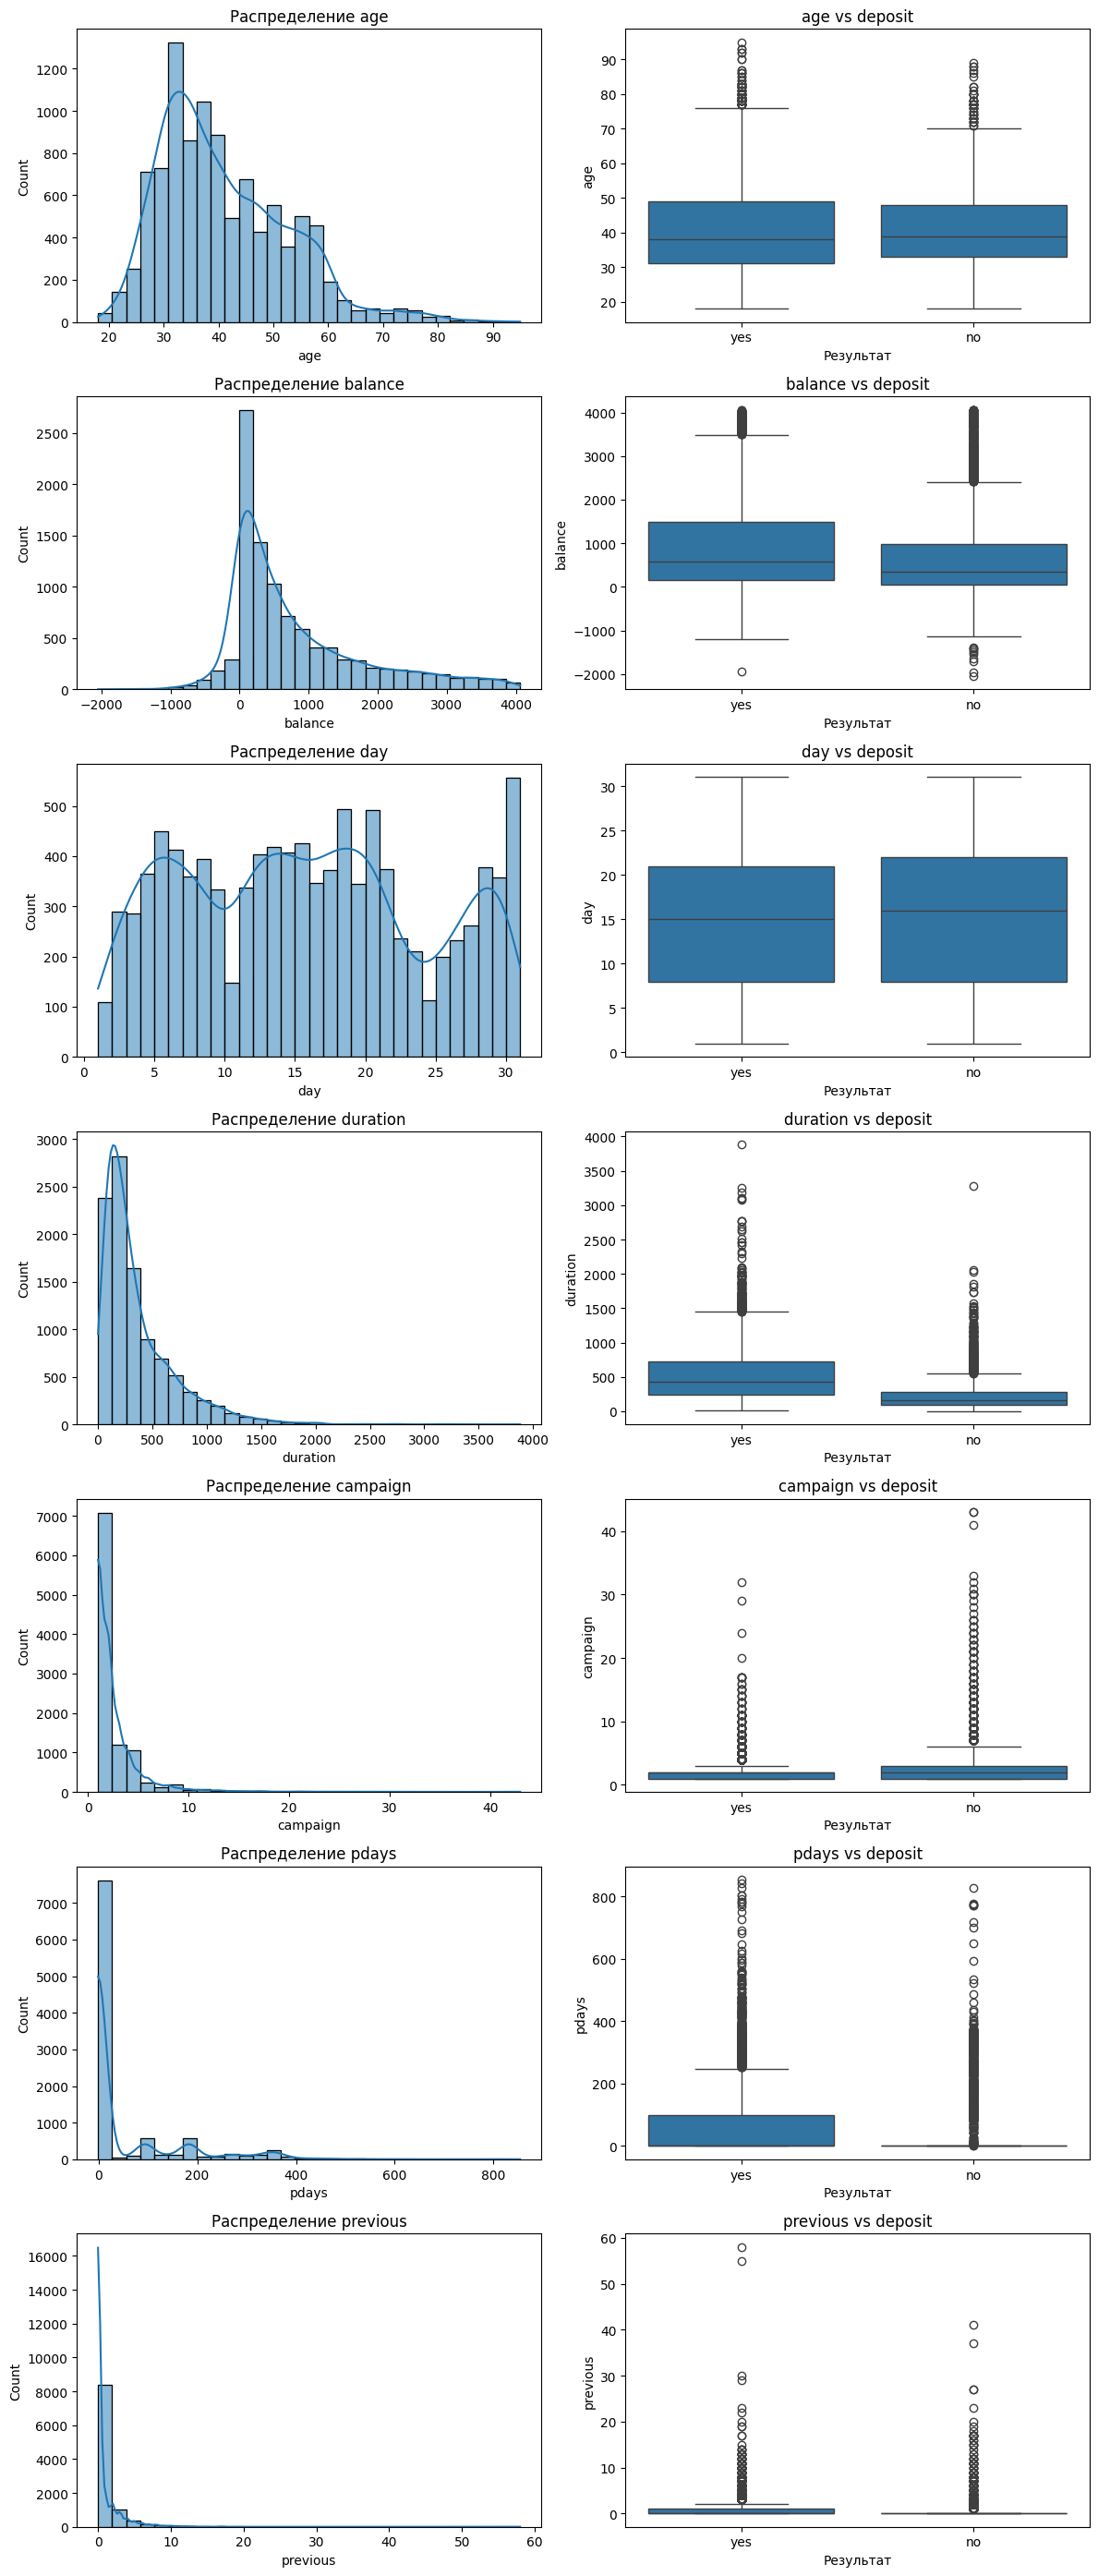

In [17]:
# Отсеиваем только числовые признаки (на данном этапе)
numeric_features = bank_df.select_dtypes(include=['int64', 'float64'])

# Сохраняем целевую переменную отдельно
target = bank_df['deposit']

# Количество числовых признаков
num_of_rows = len(numeric_features.columns)

# Создаем фигуру и набор осей
fig, axes = plt.subplots(
    num_of_rows, 
    2,
    figsize=(12, num_of_rows * 4)  # Увеличили высоту для лучшей читаемости
)

# Основные числовые признаки
for i, feature in enumerate(numeric_features.columns):
    # Строим гистограмму распределения признака
    sns.histplot(
        data=numeric_features, 
        x=feature, 
        kde=True,  # Добавляем кривую плотности
        bins=30,  # Оптимизировали количество бинов
        ax=axes[i][0]
    )
    axes[i][0].set_title(f'Распределение {feature}')
    
    # Строим диаграмму связи с целевой переменной
    sns.boxplot(
        x=target,
        y=numeric_features[feature],
        ax=axes[i][1]
    )
    axes[i][1].set_title(f'{feature} vs deposit')
    axes[i][1].set_xlabel('Результат')
    axes[i][1].set_ylabel(feature)

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

# Вывод:

- **Возраст**. Распределение возраста близко к нормальному, с пиков в районе от 30 до 40 лет. Медиана возраста согласившихся и не согласившихся примерно одинаковая, возраст в данном случае не является решающим фактором открытия депозита.

- **Баланс**. Распределение сильно скошено вправо, есть клиенты с отрицательным балансом (долги). Медиана баланса чуть выше согласившихся на депозит. Соответственно, баланс имеет влияние на депозит, более обеспеченные клиенты чаще соглашаются на открытие депозита.

- **День**. Распределение не является нормальным, имеет пики (возможно связано с внутренними процессами в банке, зарплатные дни и т.д.), выбросов не наблюдается. Связь с депозитом не выявлено, т.к. медиана почти одинаковая. Вероятно день незначимый признак для предсказания.

- **Длительность разговора**. Распределение сильно скошено вправо, большинство звонков достаточно короткие, есть редкие но очень длительные разговоры (1 час 4 минуты). Медиана согласившихся на депозит гораздо выше, соответственно, признак длительности влияет на решение открыть депозит.

- **Кампания (количество контактов с клиентом)**. Распределение так же скошено вправо. Большинство клиентов поличили мало звонков. Медиана депозита почти одинаковая, согласившихся открыть депозит немного меньше. Как результат, частые звонки не увеличивают вероятность открытия депозита клиентом, возможно даже снижают этот фактор.

- **Количество предыдущих контактов**. Большинство клиетов не имеет предыдущего контакта, в текущей кампании это первый контакт. У согласившихся открыть депозит признак pdays в районе 0, это значит, что если с клиентом недавно контактировали, вероятность открыть депозит чуть выше.

- **Количество контактов до текущей кампании**. Большинство клиентов не контактировали ранее. Разница небольшая, но у согласившихся чуть выше. История контактов второстепенно влияет на открытие депозита.

**Важные признаки:**
- Balance
- Duration
- Pdays
- Previous (+ / -)

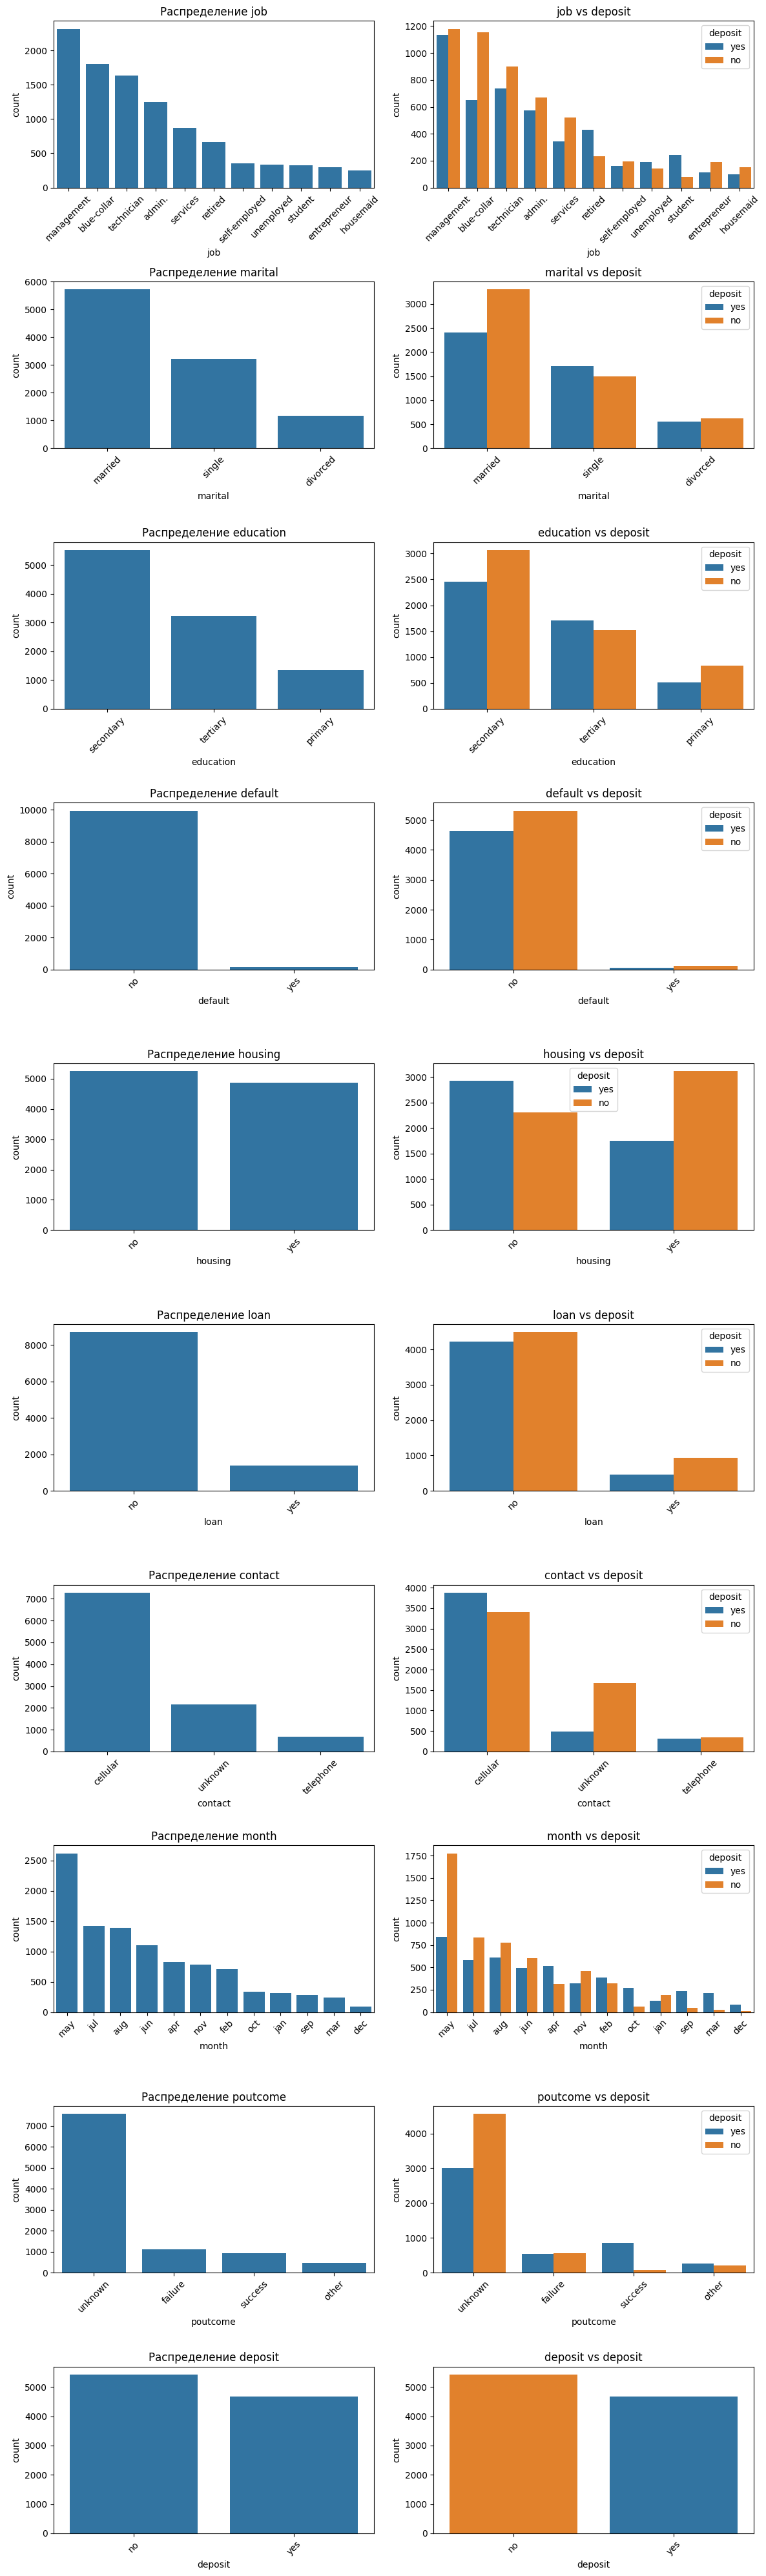

In [18]:
# Отсеиваем только категориальные признаки (на данном этапе)
categorical_features = bank_df.select_dtypes(include=['object'])

# Сохраняем целевую переменную отдельно
target = bank_df['deposit']

# Количество числовых признаков
num_of_rows = len(categorical_features.columns)

# Создаем фигуру и набор осей
fig, axes = plt.subplots(
    num_of_rows, 
    2,
    figsize=(12, num_of_rows * 4)  # Увеличили высоту для лучшей читаемости
)

# Основные числовые признаки
for i, feature in enumerate(categorical_features.columns):
    # Гистограмма распределения признака
    sns.countplot(
        data=categorical_features, 
        x=feature,
        order=categorical_features[feature].value_counts().index,
        ax=axes[i][0]
    )
    axes[i][0].set_title(f'Распределение {feature}')
    axes[i][0].tick_params(axis='x', rotation=45, labelsize=10)  # rotation + размер шрифта
    
    # Диаграмма связи с целевой переменной
    sns.countplot(
        data=bank_df,
        x=feature,
        hue='deposit',
        order=bank_df[feature].value_counts().index,
        ax=axes[i][1]
    )
    axes[i][1].set_title(f'{feature} vs deposit')
    axes[i][1].tick_params(axis='x', rotation=45, labelsize=10)  # rotation + размер шрифта

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

# Вывод:

- **Работа**. Распределение представлено больше всего менеджмент сегментом, голубыми воротничками (рабочий класс), техническими специальностями и в чуть в меньшей мере админами. Среди менеджмента скорее не открывают депозит. Рабочий класс не открывает депозиты. Другая картина начинается с пенсионеров и студентов, которые накапливают средства на депозитах. Связь между профессией и депозитом есть. 

- **Семейное положение**. Среди клиентов больше всего пары замужем и не открывают депозиты. Среди холостяков другая картина, эта категория клиентов в значительной мере открывает депозит. Связь между семейным статусом и депозитом есть.

- **Уровень образования**. Клиенты представлены двумя крупными категориями со средним образованием и высшим образованием. Клиенты с высшим образованием чаще открывают депозиты. Уровень образования безусловно влияет на решение открыть депозит.

- **Просроченный кредит**. Среди клиентов не людей с просроченными кредитами, в основном все обеспечивают свои кредиты вовремя. Среди этих клиентов нет готовых открывать депозит. Данный признак не влияет в значительное мере на положительное решение об открытии депозита.

- **Кредит на жилье (ипотека)**. В основном клиенты банка не берут ипотечные кредиты и с большей вероятностью открывают депозит. Наоборот люди имеющие ипотечные займы не открывают депозит, что совершенно логично, им необходимо обслуживать основной кредит. Этот признак может быть полезным в прогнозировании.

- **Кредит на личные нужды**. Среди всех клиентов наблюдается отсутствие кредитов на личные нужды и данный признак не влияет на решение об открытии депозита.

- **Способ связи с клиентом**. С большинством клиентов связываются через сотовую связь, что логично в современных условиях. Вторая по значимости это незвестно, скорее всего это могут быть другие способы связи, например рассылка по почте. В конечном итоге звонки по сотовому телефону в значительной мере влияют на решение об открытии депозита.

- **Месяц в котором был последний контакт**. В основном все контакты были в мае, что негативно повлияло на открытие депозита, возможно люди в отпусках неохотно соглашаются открывать депозит. В апреле, феврале, октябре, сентябре, марте и декабре наоборот более склонны открыть депозит (до наступления сезона отпусков). Данный признак влияет на открытие депозита.

- **Результат прошлой маркетинговой кампании**. В значительной мере результаты представлены как неизвестные и это не влияет на депозит. Скорее всего данный признак не будет полезным для депозита.

**Важные признаки:**
- Job
- Martial
- Education
- Housing
- Contact
- Month

In [19]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
display(bank_df[bank_df['poutcome'] == 'success'])

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
899,56,technician,married,secondary,no,589.0,yes,no,unknown,23,oct,518,1,147,2,success,yes
951,53,retired,married,tertiary,no,2269.0,no,no,cellular,17,nov,1091,2,150,1,success,yes
985,46,unemployed,divorced,secondary,no,3354.0,yes,no,cellular,19,nov,522,1,174,1,success,yes
994,40,management,married,tertiary,no,3352.0,yes,no,cellular,19,nov,639,2,27,1,success,yes
1151,31,management,married,tertiary,no,1331.0,no,no,cellular,3,feb,182,2,90,1,success,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10798,67,technician,married,secondary,no,0.0,no,no,cellular,13,aug,1152,2,188,1,success,no
10911,33,technician,married,secondary,no,348.0,yes,no,cellular,7,may,263,2,294,1,success,no
10918,36,entrepreneur,single,tertiary,no,145.0,yes,no,cellular,18,may,450,2,304,2,success,no
11069,33,self-employed,single,tertiary,no,658.0,yes,no,cellular,12,apr,93,1,173,2,success,no


In [20]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
monthly_data = bank_df.groupby('month')

# Рассчитываем процент отказов
failure_rates = monthly_data['deposit'].apply(lambda x: (x == 'no').sum() / len(x) * 100)

# Находим месяц с макс процентом отказов
problem_month = failure_rates.idxmax()
max_failure_rate = failure_rates.max()

print(f"Месяц с максимальным процентом отказов: {problem_month} ({max_failure_rate:.2f}%)")

Месяц с максимальным процентом отказов: may (67.86%)


Категорий будем использовать следующие:

* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'.

In [21]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
bins = [0, 30, 40, 50, 60, np.inf]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Создадим новый признак
bank_df['age_category'] = pd.cut(
    bank_df['age'],
    bins=bins,
    labels=labels,
    right=False
)

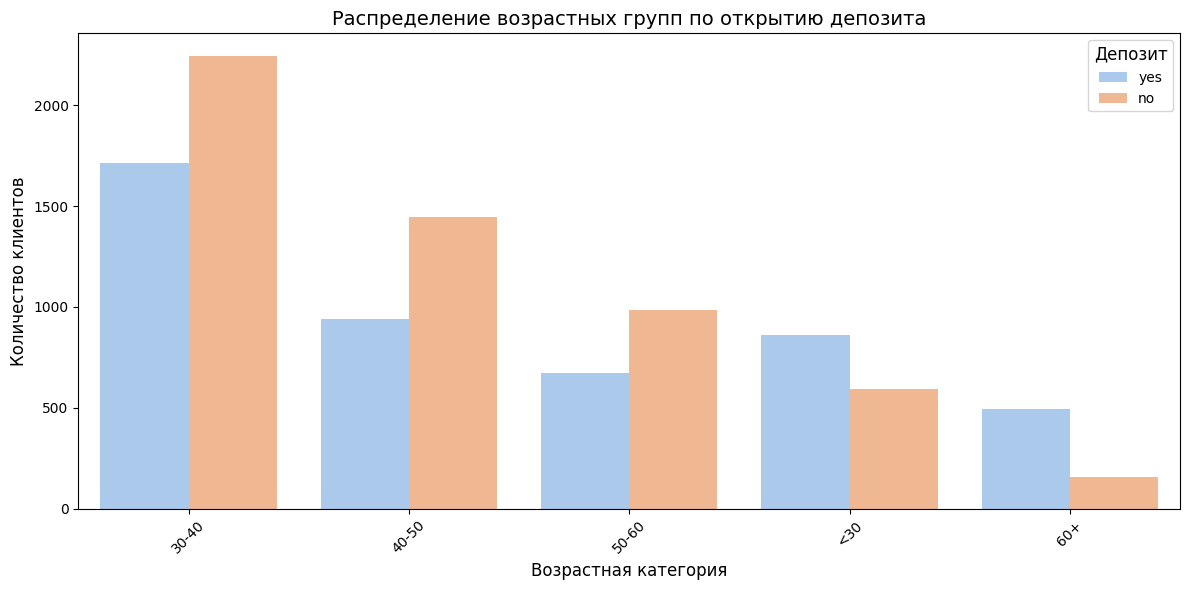

In [22]:
# Построим диаграмму отображения возрастной группы к открытию депозита
plt.figure(figsize=(12, 6))

sns.countplot(
    data=bank_df,
    x='age_category',
    hue='deposit',
    order=bank_df['age_category'].value_counts().index,
    palette='pastel'
)

# Настраиваем заголовок и подписи
plt.title('Распределение возрастных групп по открытию депозита', fontsize=14)
plt.xlabel('Возрастная категория', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Депозит', title_fontsize=12)

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

# Вывод:

Среди всех клиентов склонных открывать депозит после рекламного предложения это люди из возрастных групп старше 30 лет и пенсионеры 60 лет и старше.

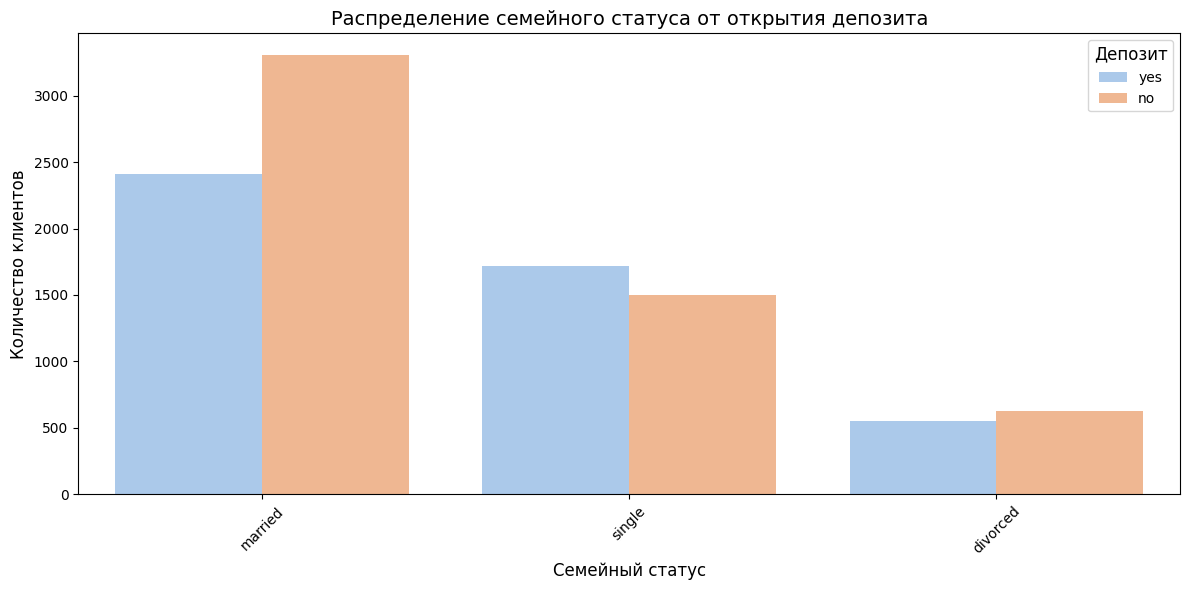

In [23]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure(figsize=(12, 6))

sns.countplot(
    data=bank_df,
    x='marital',
    hue='deposit',
    order=bank_df['marital'].value_counts().index,
    palette='pastel'
)

# Настраиваем заголовок и подписи
plt.title('Распределение семейного статуса от открытия депозита', fontsize=14)
plt.xlabel('Семейный статус', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Депозит', title_fontsize=12)

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

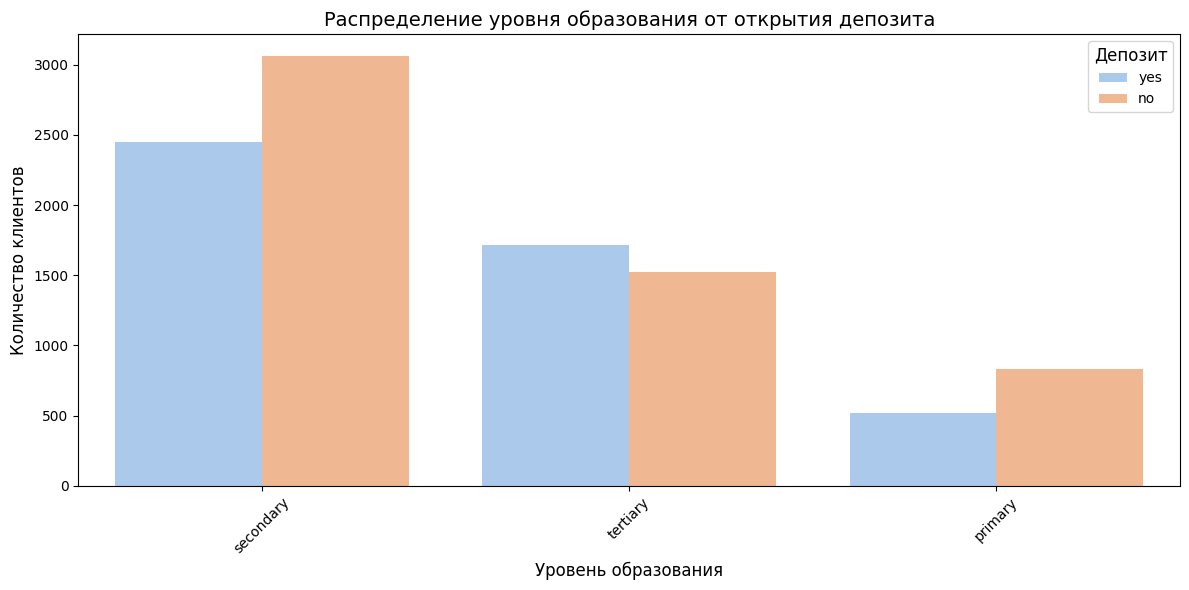

In [24]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от образования
plt.figure(figsize=(12, 6))

sns.countplot(
    data=bank_df,
    x='education',
    hue='deposit',
    order=bank_df['education'].value_counts().index,
    palette='pastel'
)

# Настраиваем заголовок и подписи
plt.title('Распределение уровня образования от открытия депозита', fontsize=14)
plt.xlabel('Уровень образования', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Депозит', title_fontsize=12)

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

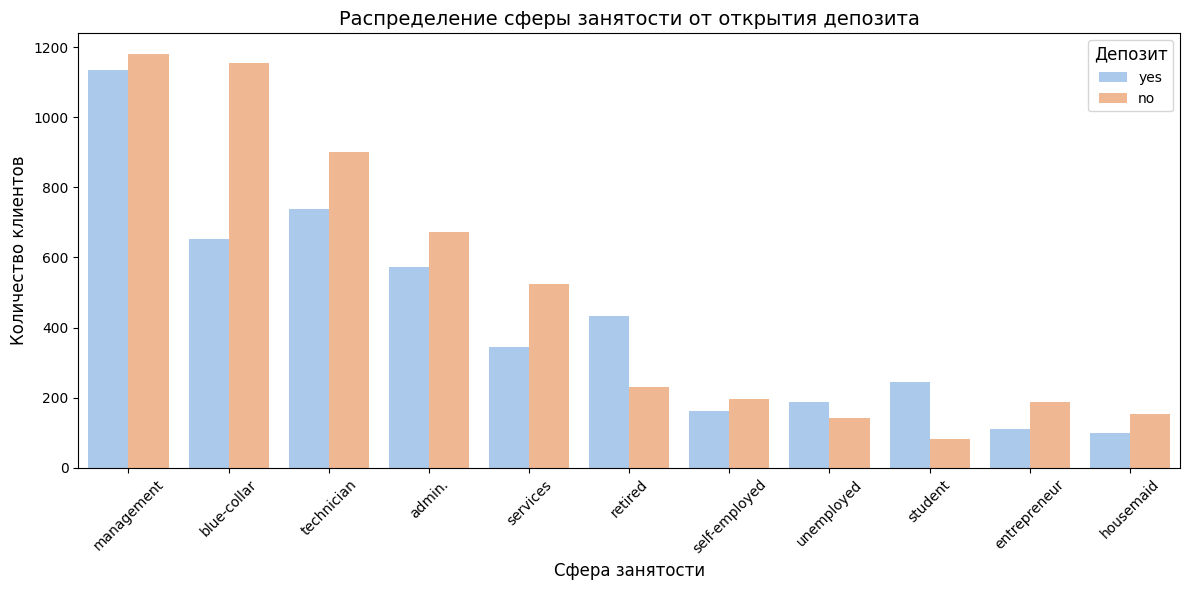

In [25]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(12, 6))

sns.countplot(
    data=bank_df,
    x='job',
    hue='deposit',
    order=bank_df['job'].value_counts().index,
    palette='pastel'
)

# Настраиваем заголовок и подписи
plt.title('Распределение сферы занятости от открытия депозита', fontsize=14)
plt.xlabel('Сфера занятости', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Депозит', title_fontsize=12)

# Плотная компоновка и отображение графиков
plt.tight_layout()
plt.show()

### Задание 11

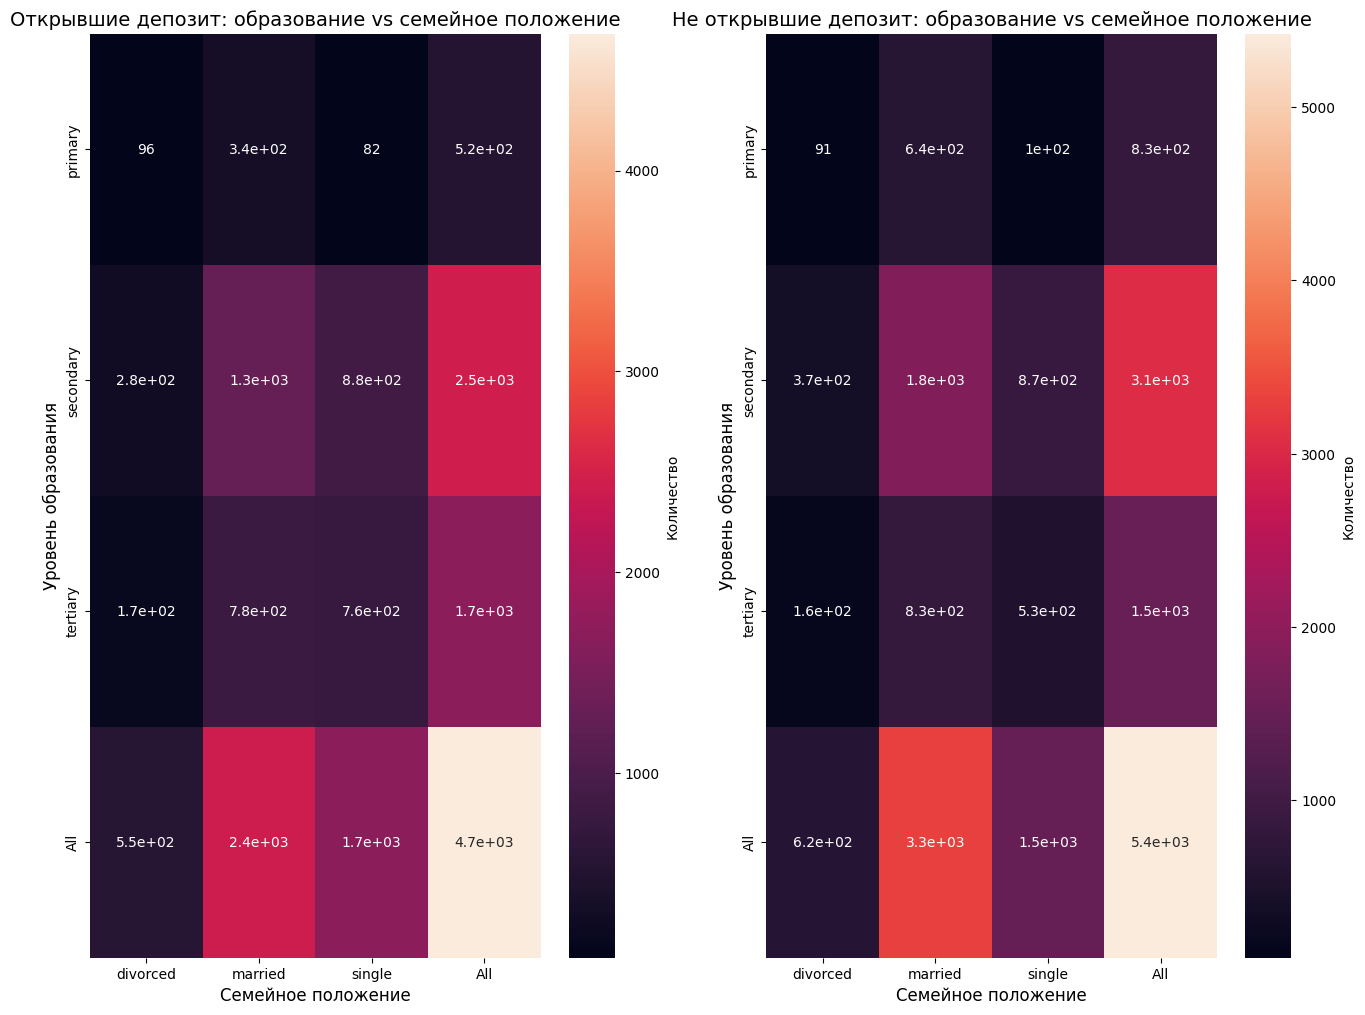

In [26]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

# разделяем данные на две группы
deposit_yes = bank_df[bank_df['deposit'] == 'yes']
deposit_no = bank_df[bank_df['deposit'] == 'no']

# Создаем сводные таблицы
# Для группы с депозитом
pivot_edu_mar_yes = pd.crosstab(
    deposit_yes['education'],
    deposit_yes['marital'],
    margins=True
)

# Для группы без депозита
pivot_edu_mar_no = pd.crosstab(
    deposit_no['education'],
    deposit_no['marital'],
    margins=True
)

# Создаем фигуру с двумя подграфиками
plt.figure(figsize=(16, 12))

# Первая тепловая карта - для открывших депозит
plt.subplot(1, 2, 1)
sns.heatmap(
    pivot_edu_mar_yes,
    annot=True,
    cbar_kws={'label': 'Количество'}
)
plt.title('Открывшие депозит: образование vs семейное положение', fontsize=14)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Уровень образования', fontsize=12)

# Вторая тепловая карта - для не открывших депозит
plt.subplot(1, 2, 2)
sns.heatmap(
    pivot_edu_mar_no,
    annot=True,
    cbar_kws={'label': 'Количество'}
)
plt.title('Не открывшие депозит: образование vs семейное положение', fontsize=14)
plt.xlabel('Семейное положение', fontsize=12)
plt.ylabel('Уровень образования', fontsize=12)

plt.show()

# Вывод:

Самой многочисленной группой в банке является женатые пары со средним уровнем образования. Разведенные и одинокие реже открывают депозиты, но их доля выше среди тех, кто не открыл депозит. Среди клиентов открывших депозит можно выделить людей женатых со средним уровнем образования, однако люди с высшим уровенем образования чаще открывают депозит. Таким образом уровень образования оказывает большее влияние на решение открыть депозит, чем семейное положение.

# 3. Преобразование данных

### education

In [27]:
display(bank_df['education'].unique())
print(f'До преобразования: {bank_df['education'].value_counts()}')

# преобразуем уровни образования и выберем в качестве метода LabelEncoder, 
# поскольку признаков education всего 3
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Применяем кодирование к столбцу
bank_df['education'] = label_encoder.fit_transform(bank_df['education'])

display(bank_df['education'].unique())
print(f'После преобразования: {bank_df['education'].value_counts()}')
display(f'Сумма получившихся значений для признака education: {bank_df['education'].sum()}')

array(['secondary', 'tertiary', 'primary'], dtype=object)

До преобразования: education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64


array([1, 2, 0])

После преобразования: education
1    5517
2    3239
0    1349
Name: count, dtype: int64


'Сумма получившихся значений для признака education: 11995'

### deposit (целевой признак)

In [28]:
display(bank_df['deposit'].unique())
print(f'До преобразования: {bank_df['deposit'].value_counts()}')

# преобразуем целевую переменную в бинарный признак yes = 1, no = 0
bank_df['deposit'] = bank_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

display(bank_df['deposit'].unique())
print(f'После преобразования: {bank_df['deposit'].value_counts()}')
display(f'Стандартное отклонение для признака deposit: {bank_df['deposit'].std():.3f}')

array(['yes', 'no'], dtype=object)

До преобразования: deposit
no     5424
yes    4681
Name: count, dtype: int64


array([1, 0])

После преобразования: deposit
0    5424
1    4681
Name: count, dtype: int64


'Стандартное отклонение для признака deposit: 0.499'

### Порядковые признаки: default, housing, loan

In [29]:
# преобразуем бинарные переменные в представление из нулей и единиц
binary_features = ['default', 'housing', 'loan']
mean_counts = []

for feature_name in binary_features:
    display(bank_df[feature_name].unique())
    print(f'До преобразования: {bank_df[feature_name].value_counts()}')

    # преобразуем целевую переменную в бинарный признак yes = 1, no = 0
    bank_df[feature_name] = bank_df[feature_name].apply(lambda x: 1 if x == 'yes' else 0)

    display(bank_df[feature_name].unique())
    print(f'После преобразования: {bank_df[feature_name].value_counts()}')
    # Добавляем среднее арифметическое для каждого признака
    mean_counts.append(bank_df[feature_name].mean())

# Просто суммируем и получаем итог по всем трем преобразованным признакам
display(f'Cумма всех признаков: {np.sum(mean_counts):.3f}')

array(['no', 'yes'], dtype=object)

До преобразования: default
no     9939
yes     166
Name: count, dtype: int64


array([0, 1])

После преобразования: default
0    9939
1     166
Name: count, dtype: int64


array(['yes', 'no'], dtype=object)

До преобразования: housing
no     5243
yes    4862
Name: count, dtype: int64


array([1, 0])

После преобразования: housing
0    5243
1    4862
Name: count, dtype: int64


array(['no', 'yes'], dtype=object)

До преобразования: loan
no     8712
yes    1393
Name: count, dtype: int64


array([0, 1])

После преобразования: loan
0    8712
1    1393
Name: count, dtype: int64


'Cумма всех признаков: 0.635'

### Номинальные признаки: job, marital, contact, month, poutcome

Примечание: В данном случае все категории этих признаков я рассматриваю без учета последовательности (месяцы), как отдельные категории, это важно.

In [30]:
# создадим дамми-переменные
dummy_features = ['job', 'marital', 'contact', 'month', 'poutcome']

# Сохраним исходный датафрейм
original_columns = bank_df.columns
original_feature_count = len(original_columns) - 1  # минус целевая переменная

# Подсчет новых признаков
new_features_count = 0

for feature_name in dummy_features:
    print(f'\nОбработка признака: {feature_name}')
    print('Уникальные значения до преобразования:')
    display(bank_df[feature_name].unique())
    print('Распределение до преобразования:')
    print(bank_df[feature_name].value_counts())

    # преобразуем целевую переменную c помощью OneHotEncoded (dummy)
    dummies = pd.get_dummies(
        data=bank_df[feature_name],
        prefix=feature_name,
        dtype=int # важно для преобразования в чиловые признаки, иначе бутет bool
    )
    
    # Подсчет новых признаков
    new_features_count += len(dummies.columns)

    # Удаляем исходный признак и добавляем дамми
    bank_df = pd.concat([bank_df.drop(columns=[feature_name]), dummies], axis=1)
    
    print('\nРаспределение после преобразования:')
    print(dummies.sum())

# Итоговая проверка
print(f'\nИсходных признаков (без целевой): {original_feature_count}')
print(f'Добавленных дамми-признаков: {new_features_count}')
print(f'Итого признаков (до удаления исходных): {original_feature_count + new_features_count}')
print(f'Текущее количество признаков: {len(bank_df.columns) - 1}')  # минус целевая переменная


Обработка признака: job
Уникальные значения до преобразования:


array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

Распределение до преобразования:
job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

Распределение после преобразования:
job_admin.           1246
job_blue-collar      1807
job_entrepreneur      300
job_housemaid         252
job_management       2315
job_retired           663
job_self-employed     358
job_services          868
job_student           326
job_technician       1638
job_unemployed        332
dtype: int64

Обработка признака: marital
Уникальные значения до преобразования:


array(['married', 'single', 'divorced'], dtype=object)

Распределение до преобразования:
marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64

Распределение после преобразования:
marital_divorced    1177
marital_married     5715
marital_single      3213
dtype: int64

Обработка признака: contact
Уникальные значения до преобразования:


array(['unknown', 'cellular', 'telephone'], dtype=object)

Распределение до преобразования:
contact
cellular     7283
unknown      2161
telephone     661
Name: count, dtype: int64

Распределение после преобразования:
contact_cellular     7283
contact_telephone     661
contact_unknown      2161
dtype: int64

Обработка признака: month
Уникальные значения до преобразования:


array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

Распределение до преобразования:
month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64

Распределение после преобразования:
month_apr     830
month_aug    1385
month_dec      93
month_feb     709
month_jan     319
month_jul    1418
month_jun    1104
month_mar     237
month_may    2617
month_nov     780
month_oct     335
month_sep     278
dtype: int64

Обработка признака: poutcome
Уникальные значения до преобразования:


array(['unknown', 'other', 'failure', 'success'], dtype=object)

Распределение до преобразования:
poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

Распределение после преобразования:
poutcome_failure    1109
poutcome_other       481
poutcome_success     945
poutcome_unknown    7570
dtype: int64

Исходных признаков (без целевой): 17
Добавленных дамми-признаков: 33
Итого признаков (до удаления исходных): 50
Текущее количество признаков: 45


### Матрица корреляций

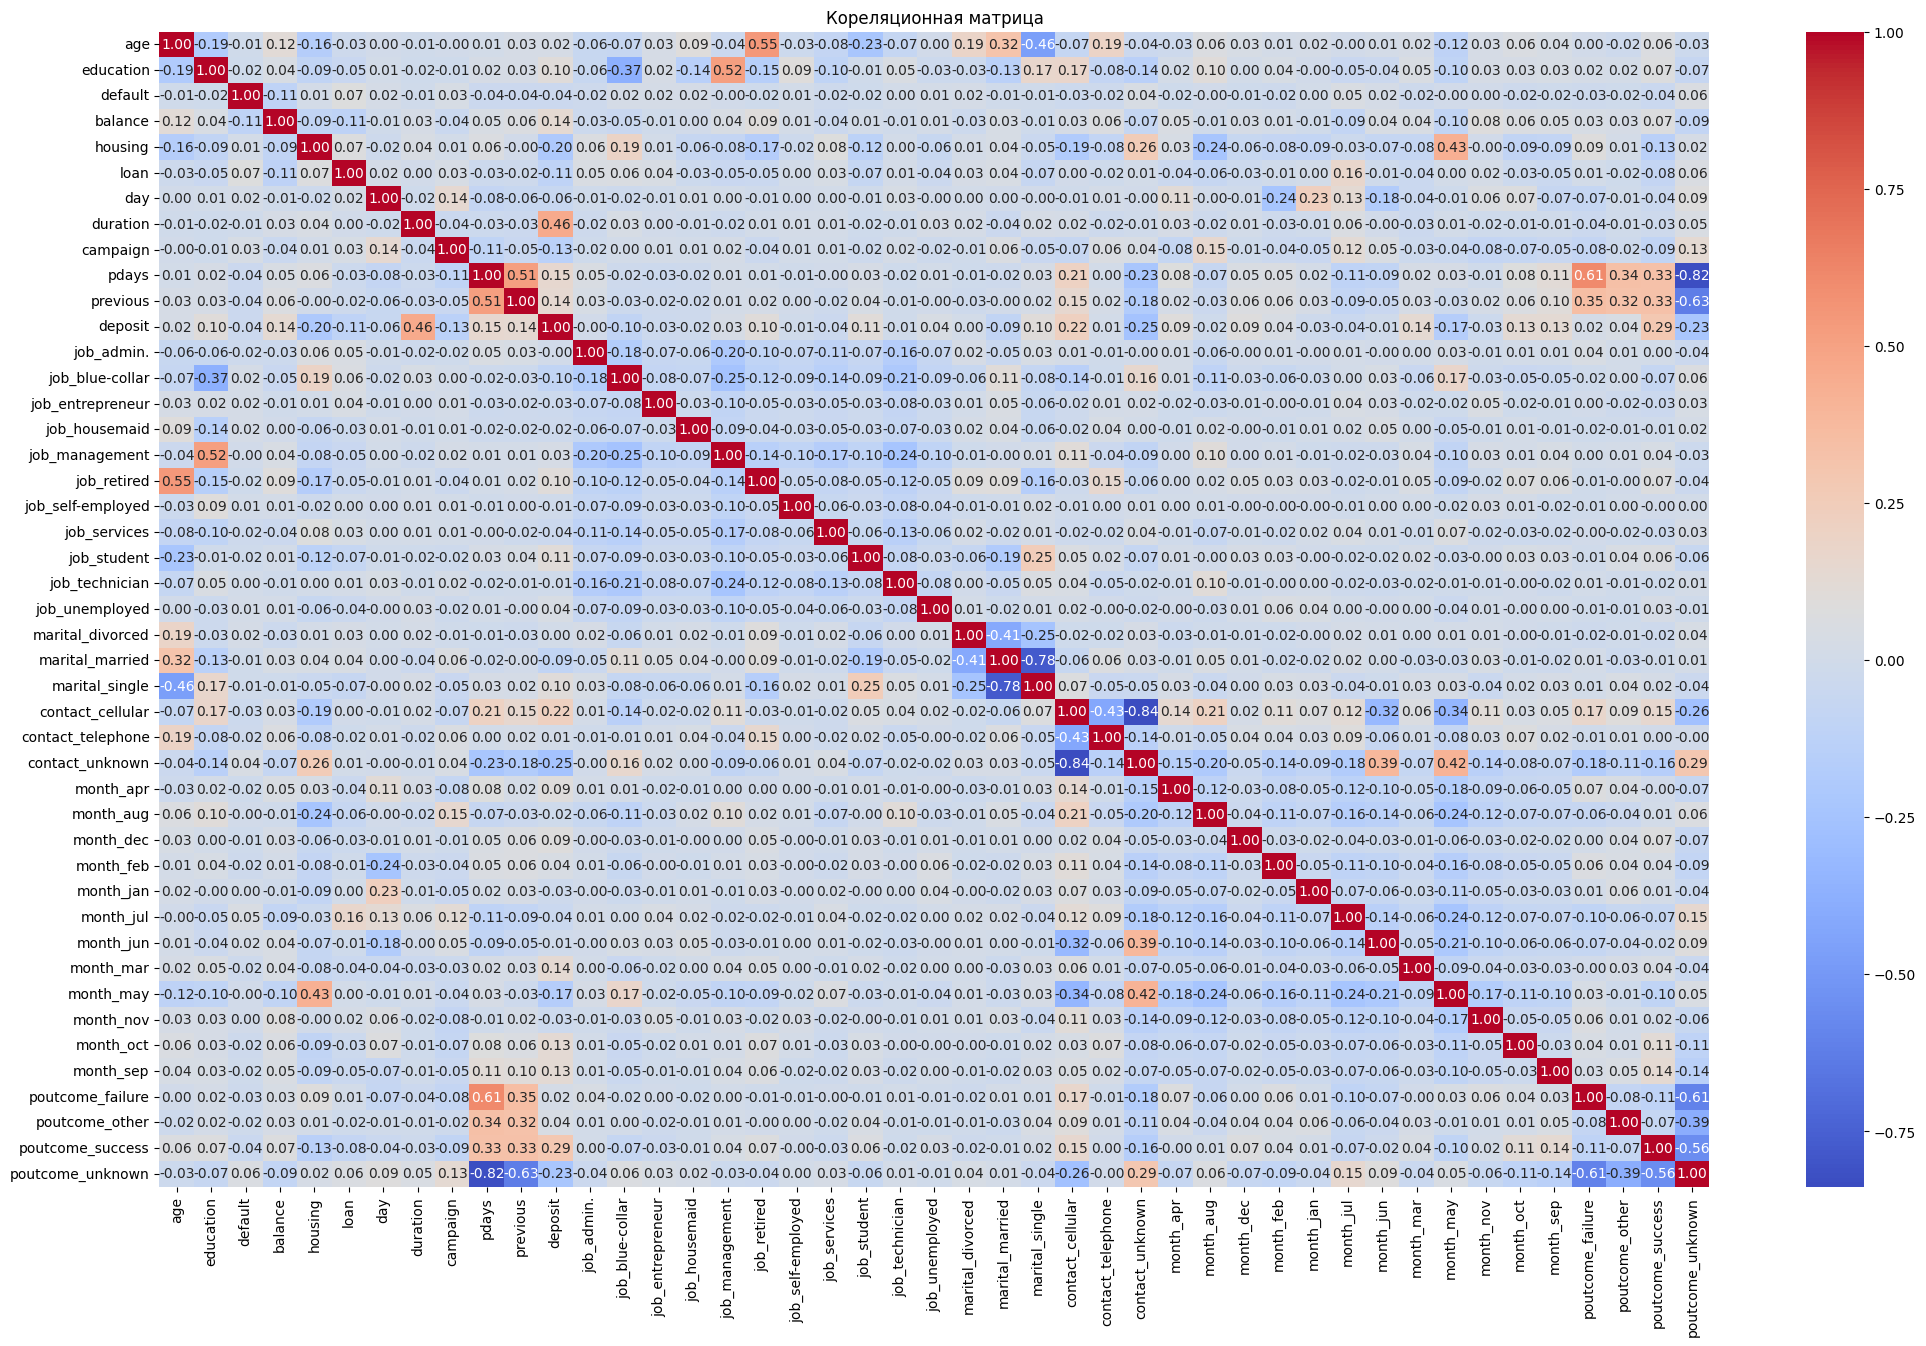

In [31]:
# Удалим ее поскольку у нас уже есть признак age
bank_df = bank_df.drop('age_category', axis=1)

# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr_matrix = bank_df.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('Кореляционная матрица')
plt.show()

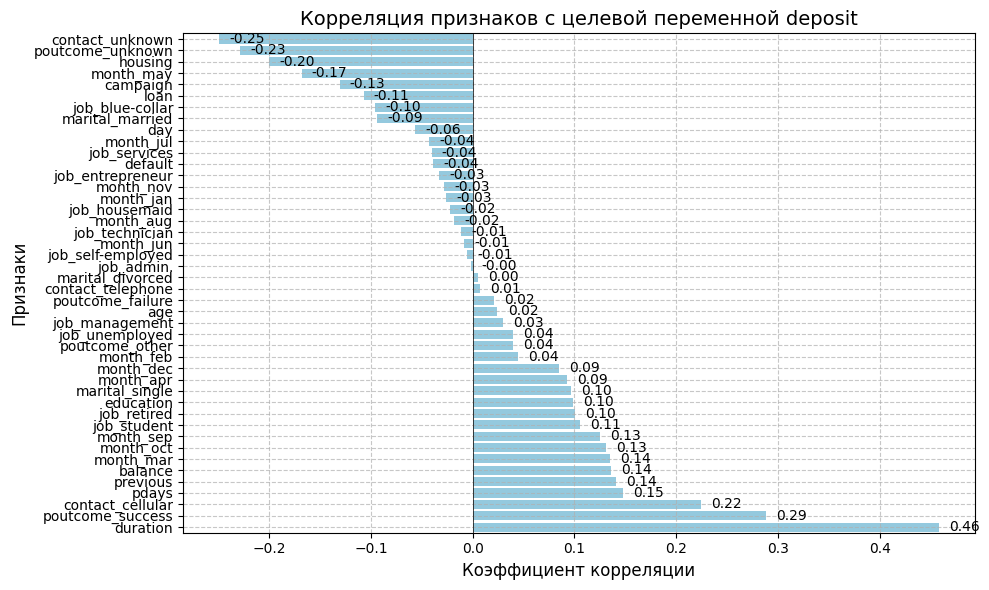

In [32]:
# Получаем корреляцию с целевой переменной
target_correlations = corr_matrix['deposit'].sort_values(ascending=True)

# Удаляем саму целевую переменную из анализа
target_correlations = target_correlations.drop('deposit')

# Создаем диаграмму
plt.figure(figsize=(10, 6))

# Строим столбчатую диаграмму
sns.barplot(
    x=target_correlations.values,
    y=target_correlations.index,
    color='skyblue'
)

# Добавляем улучшения визуализации
plt.title('Корреляция признаков с целевой переменной deposit', fontsize=14)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем значения корреляции на график
for i, v in enumerate(target_correlations.values):
    plt.text(v + 0.01, i, f'{v:.2f}', color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Вывод:

Таким образом можно сказать, что наиболее важные три признака влияющие на целевую переменную с точки зрения коэффициентов корреляции связи это:
- duration - 0.46
- poutcome_success - 0.29
- contact_cellular - 0.22

### Разделение выборки

In [33]:
X = bank_df.drop(['deposit'], axis=1)
y = bank_df['deposit']
 
# Добавим аргумент сохранения соотношений целевого признака (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

In [34]:
# рассчитаем размер тестовой выборки
print(f'Размер тестовой выборки: {X_test.shape}')
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер среднего значения целевой переменной на тестовой выборки: {y_test.mean():.2f}')

Размер тестовой выборки: (3335, 44)
Размер обучающей выборки: (6770, 44)
Размер среднего значения целевой переменной на тестовой выборки: 0.46


In [35]:
# с помощью SelectKBest отберем примерно 15 наиболее подходящих признаков
# Создаем объект отбора признаков
k_best = SelectKBest(k=15, score_func=f_classif)

# # Применяем отбор признаков по обучающей выборке 
k_best.fit_transform(X_train, y_train)

# Получаем информацию о выбранных признаках
select_mask = k_best.get_support()
selected_features = X_train.columns[select_mask]

print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [36]:
# нормализуем данные с помощью MinMaxScaler
# Создаем экземпляр скалера
scaler = MinMaxScaler()

# Применяем масштабирование только к обучающей выборке
# Применяем масштабирование только к обучающей выборке
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,  # сохраняем имена столбцов
    index=X_train.index
)

# К тестовой выборке применяем только transform
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,  # сохраняем имена столбцов
    index=X_test.index
)

# Проверяем результаты масштабирования
print(f'Среднее арифметическое для первого предиктора тестовой выборке: {np.mean(X_test_scaled.iloc[:, 0]):.2f}')

Среднее арифметическое для первого предиктора тестовой выборке: 0.31


# 4. Задачи классификации: логистическая регрессия и решающие деревья

### LogisticRegression

In [37]:
# обучиим логистическую регрессию и рассчитаем метрики качества (базовая модель)
# Создадим экземпляр класса
lr_model = linear_model.LogisticRegression(
    random_state=42,
    n_jobs=-1, # Для всех ядер
    solver='sag',
    max_iter=1_000)

# Обучим модель на нормализованных данных
lr_model.fit(X_train_scaled, y_train)

# Предсказание
y_test_pred = lr_model.predict(X_test_scaled)

# Рассчет метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {lr_model.__class__.__name__}: \n{report}')

Тестовая выборка для модели LogisticRegression: 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1790
           1       0.82      0.77      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### DecisionTreeClassifier

In [38]:
# обучим решающие деревья, настроим максимальную глубину (базовая модель)
# Создадим экземпляр класса
dt_model = tree.DecisionTreeClassifier(
    random_state=42,
    criterion='entropy',
    max_depth=6 # Ограничим примерно 5-6 глубину
)

# Обучим модель на нормализованных данных
dt_model.fit(X_train_scaled, y_train)

# Предсказание
y_test_pred = dt_model.predict(X_test_scaled)

# Рассчет метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {dt_model.__class__.__name__}: \n{report}')

Тестовая выборка для модели DecisionTreeClassifier: 
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1790
           1       0.78      0.79      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### GridSearch + DecisionTreeClassifier

In [39]:
# подберем оптимальные параметры с помощью gridsearch
# Определяем сетку параметров для поиска
param_grid = {
    'max_depth': [3, 5, 7], # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 7, 10], # Минимальное количество объектов для разделения узла
}

# Базовый классификатор
dt_estimator = tree.DecisionTreeClassifier(random_state=42)

# Инициализируем GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_estimator, # базовый классификатор
    param_grid=param_grid,   # сетка параметров
    scoring='f1',      # метрика оценки
    cv=5,                   # 5-кратная кросс-валидация
    n_jobs=-1,              
    verbose=1,              # подробный вывод
    return_train_score=True, # возвращать оценки на обучающей выборке
    error_score='raise',  # Обработка ошибок
)

# Запуск подбора
grid_search.fit(X_train_scaled, y_train)

# Получение лучших параметров
print(f'Лучшие параметры для {dt_estimator.__class__.__name__}: {grid_search.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры для DecisionTreeClassifier: {'max_depth': 7, 'min_samples_split': 2}


In [40]:
# Доступ к лучшей модели
best_dt = grid_search.best_estimator_

In [41]:
best_dt.fit(X_train_scaled, y_train)
y_test_pred = best_dt.predict(X_test_scaled)

report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {best_dt.__class__.__name__}: \n{report}')

Тестовая выборка для модели DecisionTreeClassifier: 
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# 5. Задачи классификации: ансамбли моделей и построение прогноза

### RandomForestClasifier

In [42]:
# обучим на наших данных случайный лес со следующими параметрами
# Cоздаем экземпляр класса
rnd_forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

# Обучаем модель
rnd_forest.fit(X_train_scaled, y_train)

# Прогноз
y_test_pred = rnd_forest.predict(X_test_scaled)

# Метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {rnd_forest.__class__.__name__}: \n{report}')

Тестовая выборка для модели RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### GradientBoostingClassifier (градиентный бустинг для лучшей точности)

In [43]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом

# Cоздаем экземпляр класса
gb_model = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Обучаем модель
gb_model.fit(X_train_scaled, y_train)

# Прогноз
y_test_pred = gb_model.predict(X_test_scaled)

# Метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {gb_model.__class__.__name__}: \n{report}')

Тестовая выборка для модели GradientBoostingClassifier: 
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1790
           1       0.82      0.88      0.85      1545

    accuracy                           0.86      3335
   macro avg       0.86      0.86      0.86      3335
weighted avg       0.86      0.86      0.86      3335




Топ-3 наиболее важных признака:
1. duration: 0.4450
2. poutcome_success: 0.1095
3. contact_unknown: 0.0677


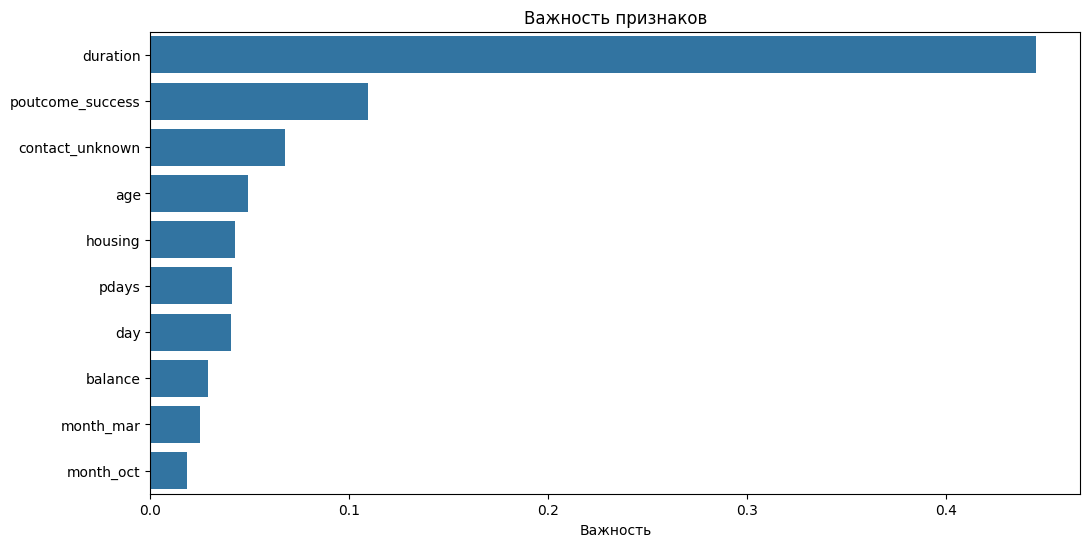

In [44]:
# Получаем важность признаков
feature_importances = gb_model.feature_importances_

# Создаем словарь с признаками и их важностью
importance_dict = dict(zip(X_train_scaled.columns, feature_importances))

# Сортируем по убыванию важности
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Выводим топ-3 наиболее важных признака
print("\nТоп-3 наиболее важных признака:")
for i, (feature, importance) in enumerate(sorted_importance[:3]):
    print(f"{i+1}. {feature}: {importance:.4f}")

# Дополнительно визуализируем важность признаков

plt.figure(figsize=(12, 6))
sns.barplot(x=[imp for _, imp in sorted_importance[:10]], 
            y=[feat for feat, _ in sorted_importance[:10]])
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.show()

# Вывод:

Если сравнить результаты c предыдущей моделью (RandomForestClassifier), где все метрики в модели градиентного бустинга выше, что безусловно является плюсом. Таким образом градиентный бустиг показывает немного лучшее качество. Кроме того, градиентный бустинг может лучше улавливать сложные зависимости в данных благодаря последовательной коррекции ошибок, однако требует больших ресурсов по сравнению со случайным лесом.

### Стекинг: DecisionTreeClasifier + LogisticRegression + GradientBoostingClasifier
**Метамодель** - LogisticRegression

In [45]:
# объединим алгоритмы с помощью стекинга
# Базовые модели
base_models = [
    ('dt', tree.DecisionTreeClassifier(
        max_depth=7, 
        min_samples_split=2
    )),
    ('lr', linear_model.LogisticRegression(
        random_state=42,
        n_jobs=-1,
        solver='sag',
        max_iter=1_000
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    )),
    ('rf', ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
    ))
]

# Создание стекинг-модели
stacking_model = ensemble.StackingClassifier(
    estimators=base_models,
    final_estimator=linear_model.LogisticRegression(
        max_iter=1_000, 
        random_state=42
    ),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

# Обучение модели
stacking_model.fit(X_train_scaled, y_train)

# Предсказания
y_test_pred = stacking_model.predict(X_test_scaled)

# Метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели {stacking_model.__class__.__name__}: \n{report}')

Тестовая выборка для модели StackingClassifier: 
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Optuna + RandomForestClassifier

In [46]:
# реализуем оптимизацию гиперпараметров с помощью Optuna для случайного леса

# Функция для оптимизации
def objective(trial):
    # Параметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', low=100, high=200, step=1)
    max_depth = trial.suggest_int('max_depth', low=10, high=30, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=2, high=10, step=1)
    
    # Создание модели
    rf_model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Кросс-валидация для оценки качества
    accuracy = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=5,
        scoring='accuracy'
    ).mean()
    
    return accuracy

In [47]:
# Настройка Optuna
optuna_study = optuna.create_study(direction='maximize')
optuna_study.optimize(objective, n_trials=50) # Количество итераций

# Вывод лучших параметров
print("Лучшие параметры:")
print(optuna_study.best_params)
print(f"Лучшая точность: {optuna_study.best_value:.4f}")

# Создание финальной модели
best_rf_model = ensemble.RandomForestClassifier(
    n_estimators=optuna_study.best_params['n_estimators'],
    max_depth=optuna_study.best_params['max_depth'],
    min_samples_leaf=optuna_study.best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

# Обучение финальной модели
best_rf_model.fit(X_train_scaled, y_train)

# Оценка на тестовой выборке
y_test_pred = best_rf_model.predict(X_test_scaled)

# Метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели Optuna + {best_rf_model.__class__.__name__}: \n{report}')

[I 2025-09-05 12:57:31,411] A new study created in memory with name: no-name-714ff9de-0c9b-4e67-b6fb-6bf32d132360
[I 2025-09-05 12:57:33,112] Trial 0 finished with value: 0.8425406203840472 and parameters: {'n_estimators': 124, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8425406203840472.
[I 2025-09-05 12:57:35,539] Trial 1 finished with value: 0.8491875923190546 and parameters: {'n_estimators': 168, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8491875923190546.
[I 2025-09-05 12:57:38,025] Trial 2 finished with value: 0.8573116691285081 and parameters: {'n_estimators': 186, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8573116691285081.
[I 2025-09-05 12:57:40,393] Trial 3 finished with value: 0.8549483013293944 and parameters: {'n_estimators': 180, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8573116691285081.
[I 2025-09-05 12:57:42,415] Trial 4 finished with value: 0.851403249630723

Лучшие параметры:
{'n_estimators': 170, 'max_depth': 17, 'min_samples_leaf': 2}
Лучшая точность: 0.8589
Тестовая выборка для модели Optuna + RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1790
           1       0.81      0.88      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



# Вывод:

Сравнив результаты на одной модели RandomForestClasifier, то можно сделать вывод, что без оптимизации (Optuna) модель явно показывает более низкие метрики. Оптимизация через Optuna привела к заметному улучшению качества модели! Улучшение коснулось всех основных метрик. Улучшился баланс классов, - модель стала лучше работать с обоими классами. Особенно заметен рост recall для класса 1. Так же модель стала более стабильной, улучшился общий баланс между precision и recall. Повысилась устойчивость предсказаний. Точность модели выросла с 84 % до 85 %.

# 6. Общие выводы

Проанализировав все модели и метрики к ним пришел к выводу, что оптимальной моделью для это задачи является **GradientBoostingClassifier**, так как:

1. Достигает наивысшей точности (Accuracy: 0.86)

2. Показывает лучшие метрики по классам

3. Имеет стабильные показатели F1-score

4. Обеспечивает хороший баланс между precision и recall

В качестве альтернативной модели можно использовать связку **Optuna + RandomForest**, если важна:

- Простота интерпретации

- Меньшая требовательность к ресурсам

- Стабильность результатов после оптимизации

### Сохраним основную и лучшую модель и сохраним также альтернативную модель

In [49]:
# путь, куда сохранить
path = "./models/"
# Сохраняем лучшую модель (GradientBoosting)
with open(f'{path}gradient_boosting_best_model.pkl', 'wb') as output:
    # Производим сериализацию обученной модели
    pickle.dump(gb_model, output)
    print(f"Модель сохранена в {path}")

# Сохраняем альтернативную модель (Optuna + RandomForest)
with open(f'{path}optuna_random_forest_alternative_model.pkl', 'wb') as output:
    # Производим сериализацию обученной модели
    pickle.dump(best_rf_model, output)
    print(f"Модель сохранена в {path}")

Модель сохранена в ./models/
Модель сохранена в ./models/


In [50]:
# Производим десериализацию и извлекаем модель из файла формата pkl
with open(f'{path}optuna_random_forest_alternative_model.pkl', 'rb') as pkl_file:
    best_rf_model = pickle.load(pkl_file)
    
best_rf_model

,n_estimators,170
,criterion,'gini'
,max_depth,17
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
# Оценка на тестовой выборке
y_test_pred = best_rf_model.predict(X_test_scaled)

# Метрики
report = metrics.classification_report(y_test, y_test_pred, output_dict=False)
print(f'Тестовая выборка для модели Optuna + {best_rf_model.__class__.__name__}: \n{report}')

Тестовая выборка для модели Optuna + RandomForestClassifier: 
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1790
           1       0.81      0.88      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

